In [1]:
#importing Libraries

In [28]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from plotly import tools
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import datetime as dt
import warnings
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing

warnings.filterwarnings('ignore')


In [3]:
df=pd.read_csv(r"/Users/adithkumar/Desktop/DS/Assignment/Timeseries/exchange_rate.csv               
df.head()

,date,Ex_rate
0,1990-01-01,0.7855
1,1990-02-01,0.7818
2,1990-03-01,0.7867
3,1990-04-01,0.7860
4,1990-05-01,0.7849


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7588 entries, 0 to 7587
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   date     7588 non-null   datetime64[ns]
 1   Ex_rate  7588 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 118.7 KB


In [5]:
df.isnull().sum()

date       0
Ex_rate    0
dtype: int64

In [6]:
df.describe()

,Ex_rate
count,7588.000000
mean,0.776974
std,0.136620
min,0.483297
25%,0.701422
50%,0.761377
75%,0.873477
max,1.102536


In [7]:
df.columns

Index(['date', 'Ex_rate'], dtype='object')

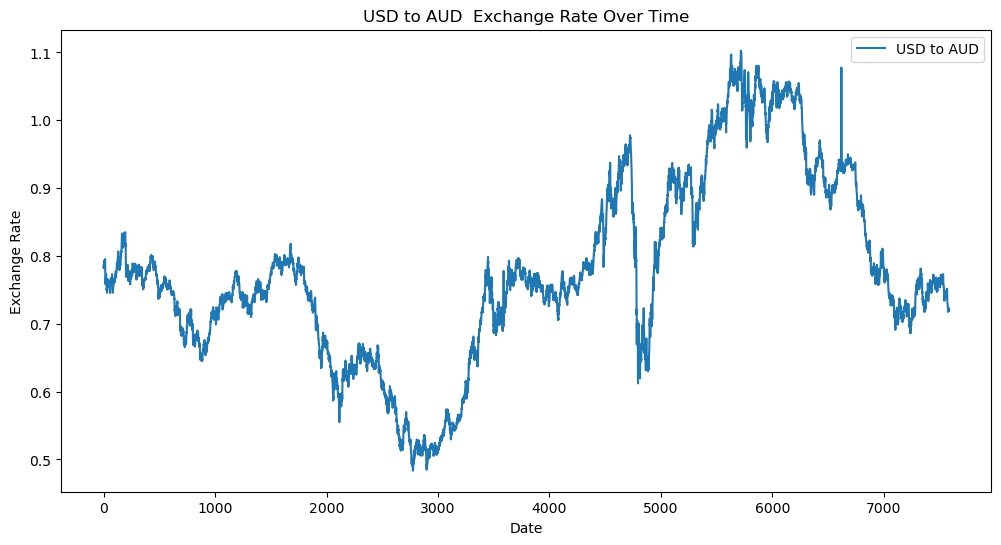

In [9]:
#plot the time series data
plt.figure(figsize=(12,6))
plt.plot(df.index,df['Ex_rate'],label='USD to AUD')
plt.title('USD to AUD  Exchange Rate Over Time')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.show()


# Part 2:Model Building - ARIMA

1.Parameter Selection for ARIMA :
    

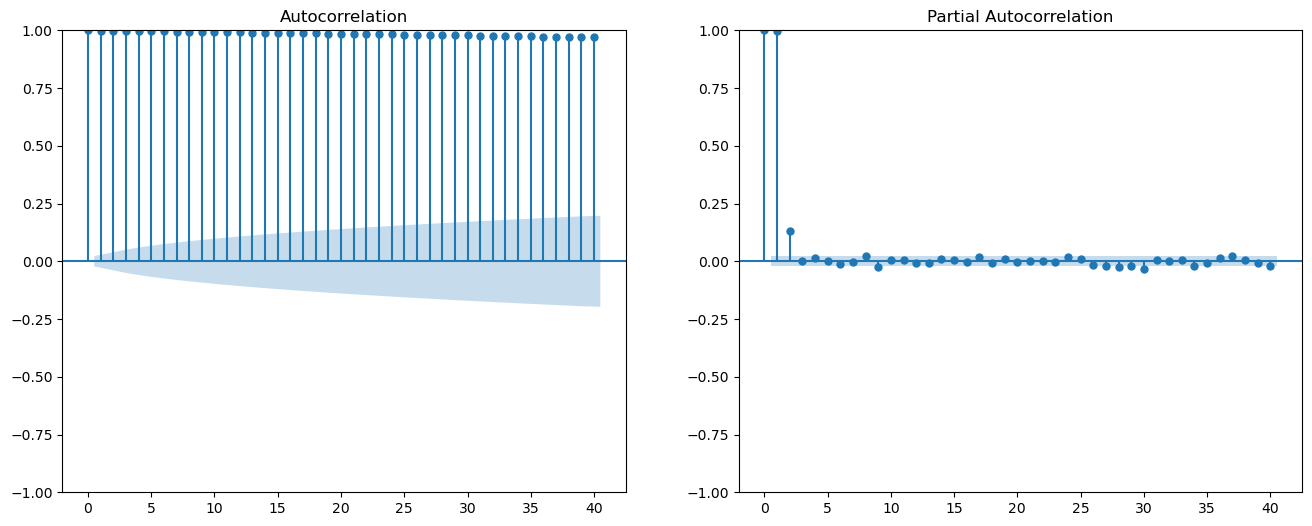

In [14]:
# Plot ACF and PACF
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
plot_acf(df['Ex_rate'], lags=40, ax=axes[0])
plot_pacf(df['Ex_rate'], lags=40, ax=axes[1])
plt.show()

# 2.Model fitting

In [18]:
# Fit the ARIMA model
# Replace p, d, q with chosen values based on ACF and PACF plots
model = ARIMA(df['Ex_rate'], order=(1, 1, 1))
arima_result = model.fit()

In [19]:
# Summary of the model
print(arima_result.summary())

                               SARIMAX Results                                
Dep. Variable:                Ex_rate   No. Observations:                 7588
Model:                 ARIMA(1, 1, 1)   Log Likelihood               28054.161
Date:                Sat, 25 May 2024   AIC                         -56102.322
Time:                        11:48:15   BIC                         -56081.519
Sample:                             0   HQIC                        -56095.182
                               - 7588                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1268      0.045     -2.797      0.005      -0.216      -0.038
ma.L1         -0.0046      0.045     -0.101      0.920      -0.094       0.085
sigma2      3.596e-05   9.94e-08    361.604      0.0

# 3. Diagnostics


In [20]:
# Residual diagnostics
residuals = arima_result.resid


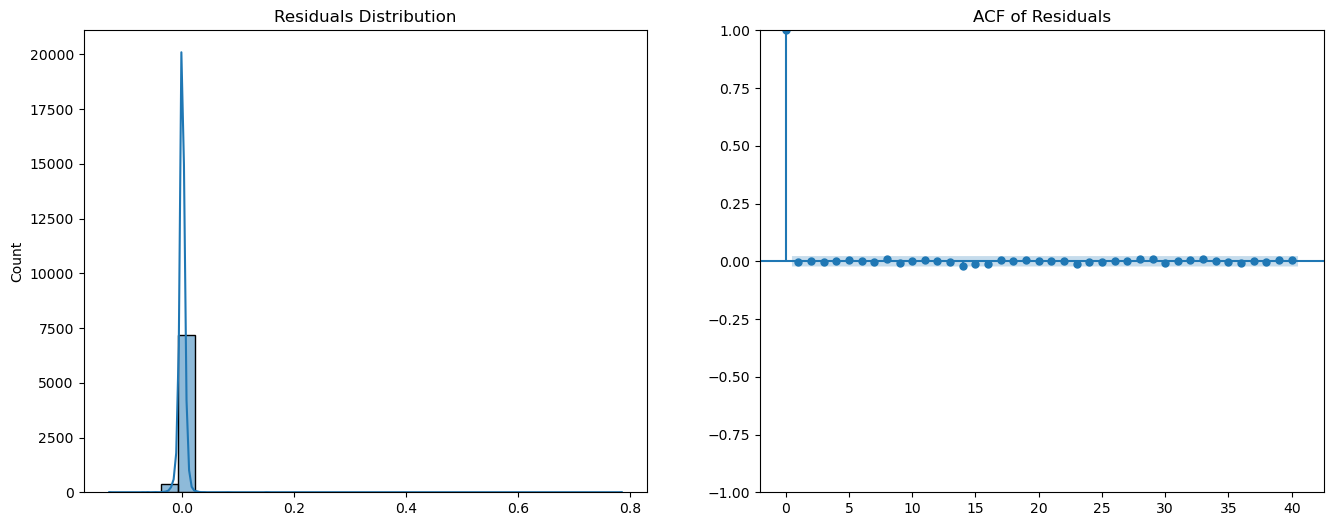

In [21]:
# Plot residuals
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
sns.histplot(residuals, bins=30, kde=True, ax=ax[0])
ax[0].set_title('Residuals Distribution')

plot_acf(residuals, lags=40, ax=ax[1])
ax[1].set_title('ACF of Residuals')
plt.show()

In [22]:
# Check for normality
from statsmodels.stats.diagnostic import acorr_ljungbox
ljung_box_result = acorr_ljungbox(residuals, lags=[10], return_df=True)
print(ljung_box_result)

    lb_stat  lb_pvalue
10  1.81673   0.997562


# 4. Forecasting


In [24]:
# Forecasting
forecast_steps = 30  # Number of steps to forecast
forecast = arima_result.get_forecast(steps=forecast_steps)
forecast_index = pd.date_range(start=df.index[-1], periods=forecast_steps + 1, freq='B')[1:]


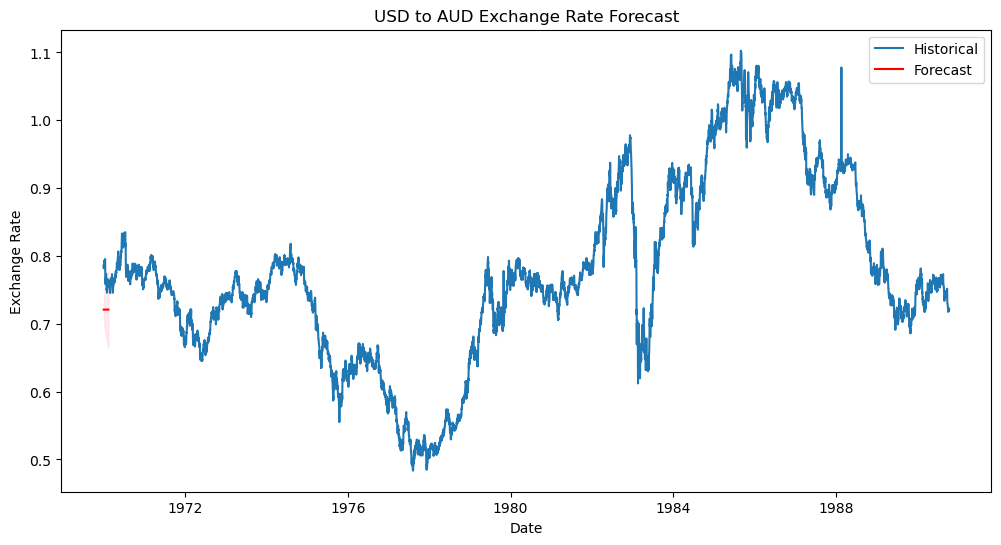

In [26]:
# Plot forecast
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Ex_rate'], label='Historical')
plt.plot(forecast_index, forecast.predicted_mean, label='Forecast', color='red')
plt.fill_between(forecast_index, forecast.conf_int().iloc[:, 0], forecast.conf_int().iloc[:, 1], color='pink', alpha=0.3)
plt.title('USD to AUD Exchange Rate Forecast')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.show()

# Part 3: Model Building - Exponential Smoothing


1.Model Selection

In [30]:
# Fit Exponential Smoothing model (Holt-Winters as an example)
model_hw = ExponentialSmoothing(df['Ex_rate'], seasonal='add', seasonal_periods=12)
hw_result = model_hw.fit()

In [31]:
# Summary of the model
print(hw_result.summary())
     


                       ExponentialSmoothing Model Results                       
Dep. Variable:                  Ex_rate   No. Observations:                 7588
Model:             ExponentialSmoothing   SSE                              0.273
Optimized:                         True   AIC                         -77628.559
Trend:                             None   BIC                         -77531.478
Seasonal:                      Additive   AICC                        -77628.487
Seasonal Periods:                    12   Date:                 Sat, 25 May 2024
Box-Cox:                          False   Time:                         11:51:53
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.8698474                alpha                 True
smoothing_seasonal       

# 2. Parameter Optimization


In [32]:
# Optimizing parameters (Example using simple grid search)
import itertools

In [33]:
# Define the parameter grid
seasonal_periods = [6, 12, 24]
seasonal = ['add', 'mul', None]
trend = ['add', 'mul', None]

In [34]:
# Initialize variables to store the best model
best_aic = float('inf')
best_model = None
     

In [37]:
# Grid search
for sp, s, t in itertools.product(seasonal_periods, seasonal, trend):
    if s is None and t is None:
        continue  # Skip invalid model
    try:
        model = ExponentialSmoothing(df['Ex_rate'], seasonal=s, seasonal_periods=sp, trend=t)
        result = model.fit()
        if result.aic < best_aic:
            best_aic = result.aic
            best_model = result
    except:
        continue

In [38]:
# Best model summary
print("Best AIC:", best_aic)
print(best_model.summary())
     

Best AIC: -77641.16854301862
                       ExponentialSmoothing Model Results                       
Dep. Variable:                  Ex_rate   No. Observations:                 7588
Model:             ExponentialSmoothing   SSE                              0.273
Optimized:                         True   AIC                         -77641.169
Trend:                   Multiplicative   BIC                         -77613.431
Seasonal:                          None   AICC                        -77641.157
Seasonal Periods:                  None   Date:                 Sat, 25 May 2024
Box-Cox:                          False   Time:                         11:53:53
Box-Cox Coeff.:                    None                                         
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            0.8698271                alpha                 True
smoot

# 3. Model Fitting and Forecasting:


In [39]:

# Forecasting with best model
hw_forecast_steps = 30  # Number of steps to forecast
hw_forecast = best_model.forecast(steps=hw_forecast_steps)
hw_forecast_index = pd.date_range(start=df.index[-1], periods=hw_forecast_steps + 1, freq='B')[1:]


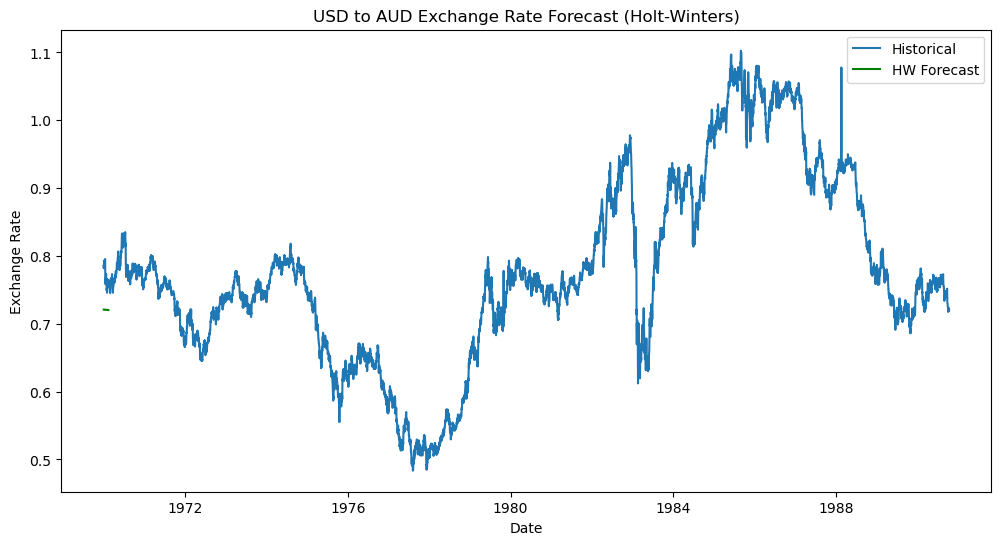

In [40]:
# Plot forecast
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Ex_rate'], label='Historical')
plt.plot(hw_forecast_index, hw_forecast, label='HW Forecast', color='green')
plt.title('USD to AUD Exchange Rate Forecast (Holt-Winters)')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.show()

# Part 4: Evaluation and Comparison


1.Computer Error Metrics:


In [42]:
from sklearn.metrics import mean_absolute_error, mean_squared_error


In [43]:
def compute_metrics(true,predicted):
    mae = mean_absolute_error(true, predicted)
    rmse = mean_squared_error(true, predicted, squared=False)
    mape = (abs((true - predicted) / true).mean()) * 100
    return mae, rmse, mape

In [45]:
# Evaluate ARIMA forecast
arima_forecast_values = forecast.predicted_mean
arima_true_values = df['Ex_rate'].iloc[-forecast_steps:]
arima_mae, arima_rmse, arima_mape = compute_metrics(arima_true_values, arima_forecast_values)


In [47]:
# Evaluate Holt-Winters forecast
hw_forecast_values = hw_forecast
hw_true_values = df['Ex_rate'].iloc[-hw_forecast_steps:]
hw_mae, hw_rmse, hw_mape = compute_metrics(hw_true_values, hw_forecast_values)
     

In [48]:
# Print error metrics
print("ARIMA - MAE: {:.4f}, RMSE: {:.4f}, MAPE: {:.2f}%".format(arima_mae, arima_rmse, arima_mape))
print("Holt-Winters - MAE: {:.4f}, RMSE: {:.4f}, MAPE: {:.2f}%".format(hw_mae, hw_rmse, hw_mape))


ARIMA - MAE: 0.0127, RMSE: 0.0170, MAPE: nan%
Holt-Winters - MAE: 0.0128, RMSE: 0.0171, MAPE: nan%


# 2. Model Comparison


In [49]:
# Compare the performance of the models
print("ARIMA Model Evaluation:")
print("MAE: {:.4f}, RMSE: {:.4f}, MAPE: {:.2f}%".format(arima_mae, arima_rmse, arima_mape))
print("\nHolt-Winters Model Evaluation:")
print("MAE: {:.4f}, RMSE: {:.4f}, MAPE: {:.2f}%".format(hw_mae, hw_rmse, hw_mape))

ARIMA Model Evaluation:
MAE: 0.0127, RMSE: 0.0170, MAPE: nan%

Holt-Winters Model Evaluation:
MAE: 0.0128, RMSE: 0.0171, MAPE: nan%


# 3. Conclusion


In [51]:
# Conclusion based on the evaluation metrics
if arima_rmse < hw_rmse:
    print("The ARIMA model performed better in terms of RMSE.")
else:
    print("The Holt-Winters model performed better in terms of RMSE.")


The ARIMA model performed better in terms of RMSE.
